In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import distinct
from sqlalchemy import desc
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


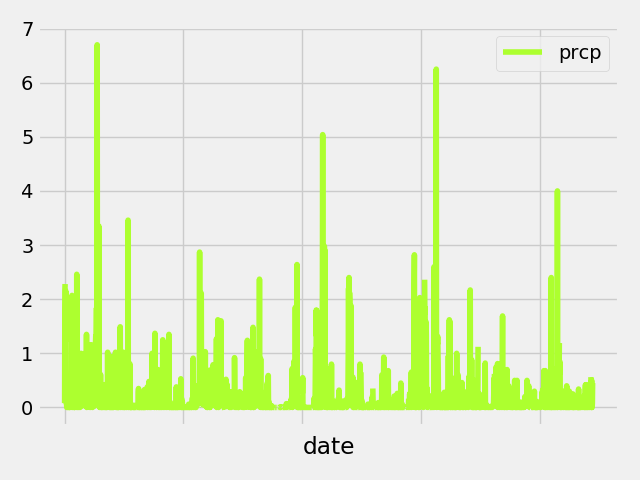

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = dt.datetime(2017, 8, 23)
year_data = date - dt.timedelta(days = 365)
date_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_data).\
    order_by(Measurement.date).all() 
df = pd.DataFrame(date_data)
df.set_index("date", inplace=True)
df.plot(x_compat=True, color='greenyellow') 
plt.xticks(rotation='45')
plt.tight_layout()
plt.savefig("Date vs Precipitation")
plt.show()

In [12]:
# Calculate the date 1 year ago from today
year_data = dt.date.today() - dt.timedelta(days = 365)
year_data

datetime.date(2017, 8, 11)

In [89]:
# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.prcp).first()

(0.08)

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
data = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date).all() 
df = pd.DataFrame(data)
df.set_index("date", inplace=True)
df.head()

prcp
date            
2010-01-01  0.08
2010-01-01  0.28
2010-01-01  0.21
2010-01-01  0.15
2010-01-01  0.15

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data = session.query(Measurement.prcp).all()
precip_data_df = pd.DataFrame(precip_data)
precip_data_df.describe()

prcp
count  18103.000000
mean       0.160644
std        0.468746
min        0.000000
25%        0.000000
50%        0.010000
75%        0.110000
max       11.530000

In [16]:
# How many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order
session.query(distinct(Measurement.station), func.count(Measurement.tobs))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
results = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_data).all()
station_df = pd.DataFrame(results, columns=['Station', 'Temperature', 'Date'])
station_df.head()

Station  Temperature        Date
0  USC00519281         77.0  2016-08-24
1  USC00519281         80.0  2016-08-25
2  USC00519281         80.0  2016-08-26
3  USC00519281         75.0  2016-08-27
4  USC00519281         73.0  2016-08-28

<IPython.core.display.Javascript object>


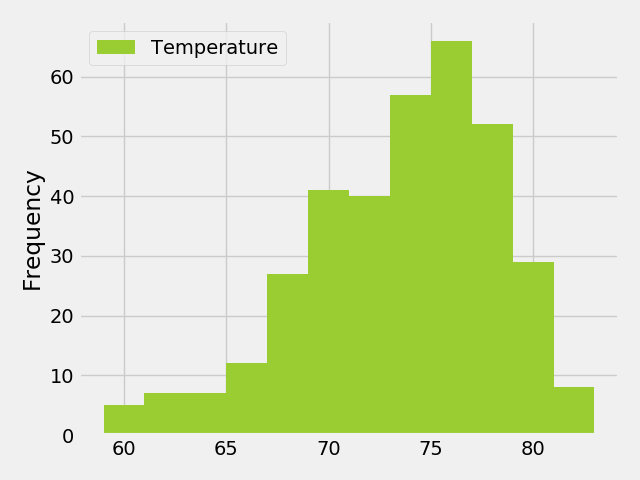

In [51]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_df.plot.hist(bins=12, color='yellowgreen')
plt.tight_layout()
plt.show()
plt.savefig('station_temp.png')

In [80]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def  calc_temps(startdate, enddate):
    minimum_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date > startdate)\
                             .filter(Measurement.date < enddate).all()
    maximum_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date > startdate)\
                             .filter(Measurement.date < enddate).all()
    average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date > startdate)\
                             .filter(Measurement.date < enddate).all()
    return minimum_temp, maximum_temp, average_temp

In [81]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_tempscalc_temp('2016-8-23', '2017-8-23')
trip

([(58.0)], [(87.0)], [(74.14387974230493)])

<IPython.core.display.Javascript object>


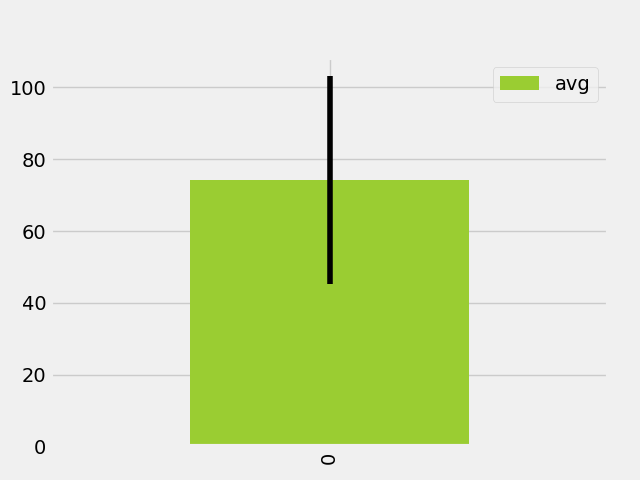

In [82]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df = pd.DataFrame({'tmin': trip[0][0], 'tmax': trip[1][0], 'avg': trip[2][0]}, columns=['tmin','avg','tmax'])

trip_temp_plot = trip_temp_df['tmax'].sub(trip_temp_df['tmin'])
trip_temp_df.plot.bar(y='avg', yerr=trip_temp_plot, color="yellowgreen")
plt.savefig("Trip_Temp_Plot.png")

In [83]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(distinct(Measurement.station), func.sum(Measurement.prcp))\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 1068.0899999999956),
 ('USC00519281', 588.6399999999976),
 ('USC00513117', 382.61999999999847),
 ('USC00519523', 295.67999999999944),
 ('USC00514830', 234.49000000000026),
 ('USC00519397', 131.62000000000063),
 ('USC00511918', 92.68000000000006),
 ('USC00518838', 70.87000000000005),
 ('USC00517948', 43.44000000000002)]

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [74]:
# Plot the daily normals as an area plot with `stacked=False`
